In [1]:
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from scipy import interpolate

#DATE REF
date_1 = datetime.datetime.strptime('01/01/1950', "%m/%d/%Y")

#IPRC
pathi = '/home1/ballycotton/DATA/IPRC/'
allFiles = glob.glob(pathi + "*.dat")
allFiles.sort()
cnames=['Lon','Lat','Level','Depth','JULD','TEMP','PSAL','POTM','PSIG','ERRT','ERRS','WMO','CYCLE']
colm=[0,1,2,3,4,5,6,7,8,12,13,20,21]
td_=[]
for file_ in allFiles:
    #print file_
    df = pd.read_csv(file_,delim_whitespace=True,index_col=None, header=None, usecols=colm, names=cnames)    
    df['JULD']=df['JULD']+18262
    df=df[((df['Lat']>20) & (df['Lat']<45) & (df['Lon']>-85) & (df['Lon']<-35))]
    td_.append(df)
endframe=pd.concat(td_,sort=False)
print endframe

            Lon      Lat  Level   Depth       JULD    TEMP    PSAL    POTM  \
585    -35.5960  41.4560      1     0.0  17827.195  20.708  35.720  20.708   
611    -36.1860  41.2440      1     0.0  17842.221  20.107  35.806  20.107   
646    -36.1200  40.9000      1     0.0  17857.174  18.977  35.903  18.977   
714    -35.9350  40.0900      1     0.0  17887.221  16.811  35.917  16.811   
746    -35.4810  39.7410      1     0.0  17902.174  16.586  36.027  16.586   
785    -35.1800  40.2950      1     0.0  17917.197  16.900  36.135  16.900   
819    -35.6000  40.8420      1     0.0  17932.221  16.245  36.057  16.245   
874    -35.7970  41.3020      1     0.0  17947.174  16.427  36.076  16.427   
923    -35.8620  41.9950      1     0.0  17962.197  16.404  36.054  16.404   
980    -35.5320  42.7920      1     0.0  17977.221  16.665  36.152  16.665   
6266   -35.7380  44.5230      1     0.0  18456.322  20.494  35.610  20.494   
6628   -35.5540  44.9970      1     0.0  18471.359  19.477  35.9

In [2]:
#YEAR TO PROCESS
yeart='2015'
montht='06'

#OCCIPUT SDL INTERPOLATION
OCCI = '/home1/ballycotton/DATA/PIRATE/SDL_INTERP/'+yeart+'/'
patho = glob.glob(os.path.join(OCCI+'*'+montht+'.nc'))
#OPEN
OCC=xr.open_dataset(patho[0],decode_times=False,mask_and_scale=True)
#
#REMOVE FIRST LEVEL (0m)
OCC=OCC.where(OCC.STANDARD_LEVELS<0,drop=True)
# ALIGN VARIABLES ALONG ONE DIMENSION 
OCC['A']=OCC.JULD.min(dim='N_LEVELS')
OCC['B']=OCC.STATION_IDENTIFIER.min(dim='N_LEVELS')
OCC['C']=OCC.LATITUDE.min(dim='N_LEVELS')
OCC['D']=OCC.LONGITUDE.min(dim='N_LEVELS')
OCC=OCC.drop(['JULD','STATION_IDENTIFIER','LATITUDE','LONGITUDE'])
OCC=OCC.rename({'A':'JULD','B':'STATION_IDENTIFIER','C':'LATITUDE','D':'LONGITUDE'})
#
OCC['FIND']= xr.DataArray(np.zeros(len(OCC.N_OBS))+1,dims= {'N_OBS'})
OCC['POTM_IPRC'] = xr.DataArray(np.zeros([len(OCC.N_OBS),299]),dims= {'N_OBS','N_LEVELS'})
OCC['PSAL_IPRC'] = xr.DataArray(np.zeros([len(OCC.N_OBS),299]),dims= {'N_OBS','N_LEVELS'})
print OCC

<xarray.Dataset>
Dimensions:             (N_LEVELS: 299, N_MEMBER: 50, N_OBS: 296)
Dimensions without coordinates: N_LEVELS, N_MEMBER, N_OBS
Data variables:
    STANDARD_LEVELS     (N_LEVELS) float64 -5.0 -10.0 -15.0 -20.0 -25.0 ...
    POTM_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 27.83 27.79 ...
    TEMP_OBS            (N_OBS, N_LEVELS) float64 28.28 28.28 28.28 28.19 ...
    CYCLE_NUMBER        (N_OBS, N_LEVELS) float64 44.0 44.0 44.0 44.0 44.0 ...
    POTM_OBS            (N_OBS, N_LEVELS) float64 28.28 28.28 28.27 28.19 ...
    PSAL_OBS            (N_OBS, N_LEVELS) float64 36.29 36.29 36.29 36.29 ...
    PSAL_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 35.97 35.97 ...
    JULD                (N_OBS) float64 2.389e+04 2.389e+04 2.389e+04 ...
    STATION_IDENTIFIER  (N_OBS) object '4901597 ' '4901587 ' '6902563 ' ...
    LATITUDE            (N_OBS) float64 23.58 33.59 42.16 24.15 24.98 20.91 ...
    LONGITUDE           (N_OBS) float64 -84.95 -52.92 -59.77 -36.63 -37.

In [3]:
for i in OCC.N_OBS.values:
    A1=endframe[endframe['WMO']==int(OCC.STATION_IDENTIFIER[i].values)]    
    if(len(A1)>0):
        A2=A1[abs(A1['JULD'] - OCC.JULD[i].values)<0.1]
        if(len(A2)>2) :
            if (min(A2['Depth'])<=5) & (max(A2['Depth'])>=1500) :
                #INTERPOLATE HERE
                ft = interpolate.interp1d(A2['Depth'], A2['POTM']-A2['ERRT'])
                fs = interpolate.interp1d(A2['Depth'], A2['PSAL']-A2['ERRS'])
                OCC.POTM_IPRC[i,:] = ft(-OCC.STANDARD_LEVELS.values)
                OCC.PSAL_IPRC[i,:] = fs(-OCC.STANDARD_LEVELS.values)   
            else:
                OCC.FIND[i]=0    
        else:
            OCC.FIND[i]=0    
    else:
        OCC.FIND[i]=0
OCC=OCC.where(OCC.FIND==1,drop=True)        
OCC['STANDARD_LEVELS'] = OCC['STANDARD_LEVELS'].isel(N_OBS=0)
OCC=OCC.drop('FIND')        

In [4]:
OCC

<xarray.Dataset>
Dimensions:             (N_LEVELS: 299, N_MEMBER: 50, N_OBS: 254)
Dimensions without coordinates: N_LEVELS, N_MEMBER, N_OBS
Data variables:
    STANDARD_LEVELS     (N_LEVELS) float64 -5.0 -10.0 -15.0 -20.0 -25.0 ...
    POTM_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 27.83 27.79 ...
    TEMP_OBS            (N_OBS, N_LEVELS) float64 28.28 28.28 28.28 28.19 ...
    CYCLE_NUMBER        (N_OBS, N_LEVELS) float64 44.0 44.0 44.0 44.0 44.0 ...
    POTM_OBS            (N_OBS, N_LEVELS) float64 28.28 28.28 28.27 28.19 ...
    PSAL_OBS            (N_OBS, N_LEVELS) float64 36.29 36.29 36.29 36.29 ...
    PSAL_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 35.97 35.97 ...
    JULD                (N_OBS) float64 2.389e+04 2.389e+04 2.389e+04 ...
    STATION_IDENTIFIER  (N_OBS) object '4901597 ' '4901587 ' '5904005 ' ...
    LATITUDE            (N_OBS) float64 23.58 33.59 24.15 24.98 20.91 24.59 ...
    LONGITUDE           (N_OBS) float64 -84.95 -52.92 -36.63 -37.07 -68.

<IPython.core.display.Javascript object>


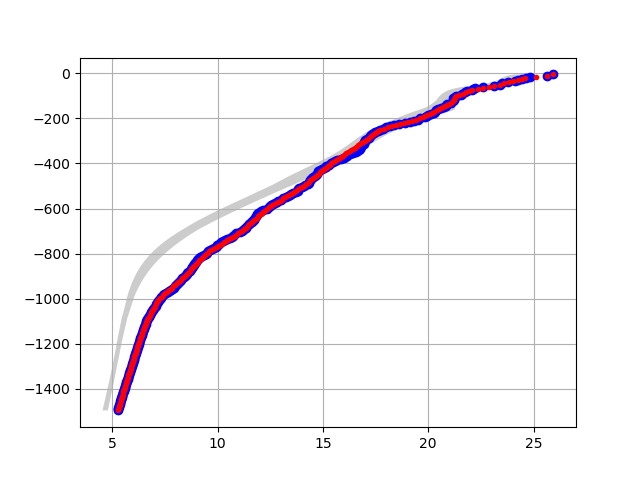

In [14]:
%matplotlib notebook
indx=212
plt.grid(True)
plt.plot(OCC.POTM_OBS[indx,:],OCC.STANDARD_LEVELS,'bo')
plt.plot(OCC.POTM_IPRC[indx,:],OCC.STANDARD_LEVELS,'r.')
plt.fill_betweenx(OCC.STANDARD_LEVELS,
                  OCC.POTM_Hx[:,indx,:].min('N_MEMBER'),
                  OCC.POTM_Hx[:,indx,:].max('N_MEMBER'),
                  facecolor='gray', alpha=0.4)